In [1]:
!pip install -U imbalanced-learn

Import libraries

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV


from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced


In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Counter({0: 284315, 1: 492})


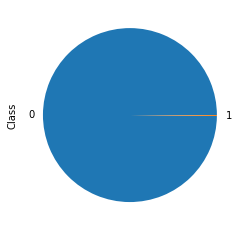

In [4]:
classes = pd.value_counts(df['Class'], sort = False)
classes.plot(kind='pie')

print(Counter(df['Class']))

First we will have to scale the columns that arent already scaled in the dataset. Those columns are time and amount.

In [5]:
std_scaler = StandardScaler()

df['time_sc'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['amount_sc'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

We had to add two new columns for simplicity so we remove the previous ones

In [6]:
df.drop(['Time','Amount'], axis=1, inplace=True)

adding the new ones to the correct place.

In [7]:
time_sc = df['time_sc']
amount_sc = df['amount_sc']

df.drop(['amount_sc', 'time_sc'], axis=1, inplace=True)
df.insert(0, 'Time', time_sc)
df.insert(29, 'Amount', amount_sc)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


The purpose of this project is to test imbalance methods so we wont do any more preprossesing at this point.

In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)
print(Counter(y_train))

Counter({0: 227462, 1: 383})


In [9]:
print(Counter(y_test))

Counter({0: 56853, 1: 109})


thats a fine split ( we tested different random states to achieve it). We have enough to do oversampling and enought for testing.

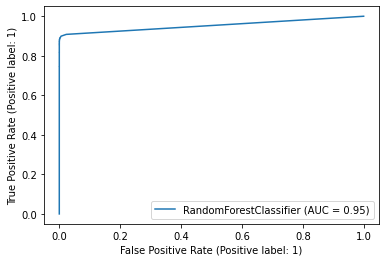

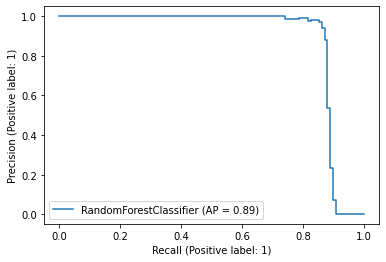

In [10]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_test, y_test)
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

!!! The SVC takes too long, so it is commented out. The results are AUC = 0.95 and  AP= 0.77.

In [11]:
#clf = SVC(kernel='linear', C=0.1)
#clf.fit(X_train, y_train)
#RocCurveDisplay.from_estimator(clf, X_test, y_test)
#PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

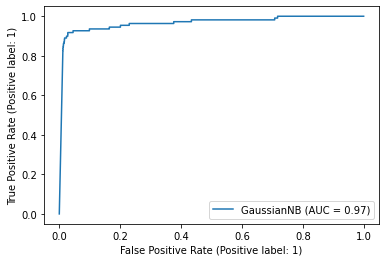

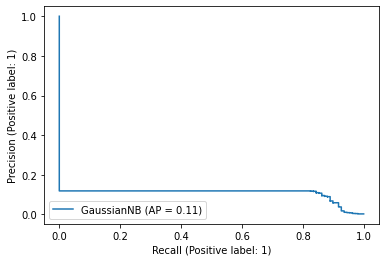

In [12]:
clf = GaussianNB()
clf.fit(X_train, y_train)
RocCurveDisplay.from_estimator(clf, X_test, y_test)
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

We have a large dataset so and the models take a long time, so oversampling is not a good idea, because of the limited time. So we are going to choose random undersampling for the first method.

In [13]:
print(Counter(y_train))

Counter({0: 227462, 1: 383})


**Method 1: Random Undersampling**

In [14]:
names = ['Random Forest', 'Linear SVM','Naive Bayes']
classifiers = [RandomForestClassifier(n_estimators=100, random_state=0), 
               SVC(kernel='linear', C=1),
               GaussianNB()]

make them equal

Random Forest
------------------------------------------------------
Confusion matrix
[[55211  1642]
 [    7   102]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.94      0.99      0.95      0.91     56853
          1       0.06      0.94      0.97      0.11      0.95      0.91       109

avg / total       1.00      0.97      0.94      0.98      0.95      0.91     56962

------------------------------------------------------

Linear SVM
------------------------------------------------------
Confusion matrix
[[54732  2121]
 [    7   102]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.94      0.98      0.95      0.90     56853
          1       0.05      0.94      0.96      0.09      0.95      0.90       109

avg / total       1.00      0.96      0.94      0.98      0.95      0.90     56962

---------------------------------------

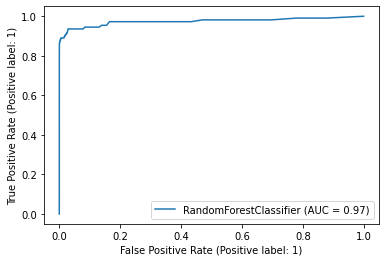

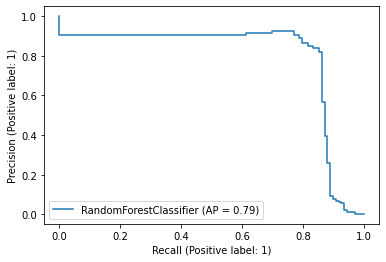

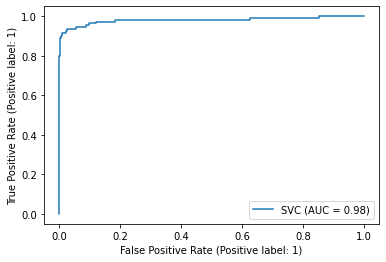

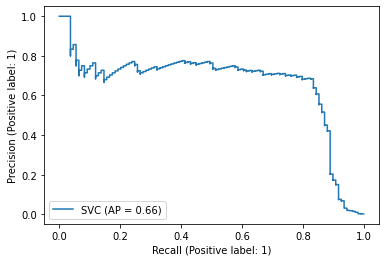

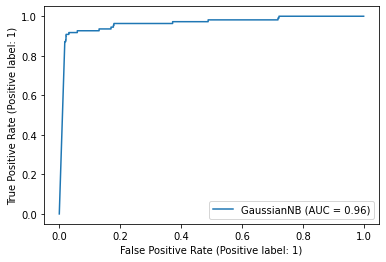

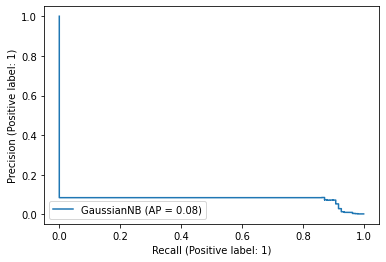

In [15]:
for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")
  sampler = RandomUnderSampler(sampling_strategy={0: 383, 1: 383}, random_state=1)
  X_train_us, y_train_us = sampler.fit_resample(X_train, y_train)

  clf.fit(X_train_us, y_train_us)
  y_pred = clf.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)

  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 

  print(classification_report_imbalanced(y_test, y_pred))

  
  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

  print("------------------------------------------------------\n")

Make majority class double the minority

Random Forest
------------------------------------------------------
Confusion matrix
[[56089   764]
 [    9   100]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.92      0.99      0.95      0.91     56853
          1       0.12      0.92      0.99      0.21      0.95      0.90       109

avg / total       1.00      0.99      0.92      0.99      0.95      0.91     56962

------------------------------------------------------

Linear SVM
------------------------------------------------------
Confusion matrix
[[55776  1077]
 [    8   101]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.93      0.99      0.95      0.91     56853
          1       0.09      0.93      0.98      0.16      0.95      0.90       109

avg / total       1.00      0.98      0.93      0.99      0.95      0.91     56962

---------------------------------------

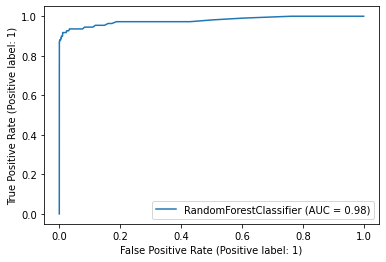

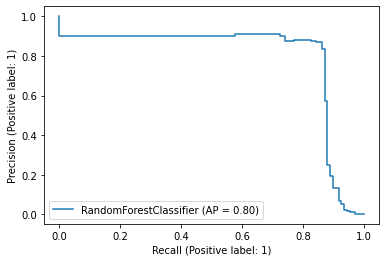

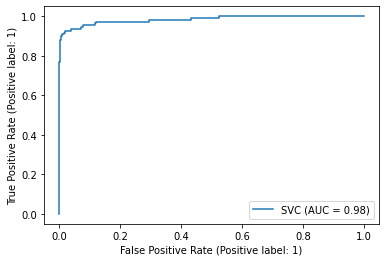

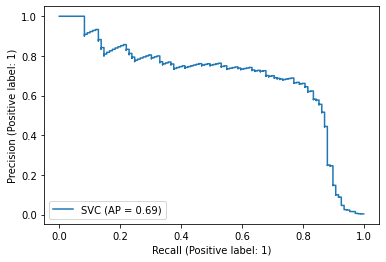

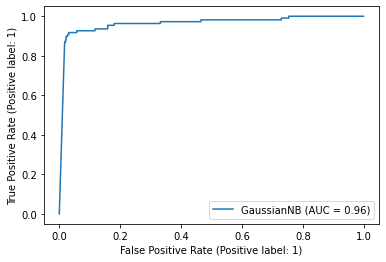

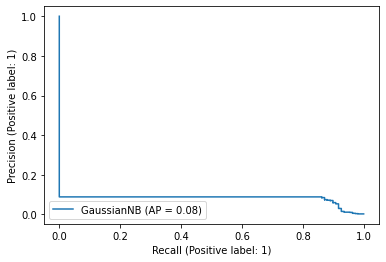

In [16]:
for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")
  sampler = RandomUnderSampler(sampling_strategy={0: 766, 1: 383}, random_state=1)
  X_train_us, y_train_us = sampler.fit_resample(X_train, y_train)

  clf.fit(X_train_us, y_train_us)
  y_pred = clf.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)

  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  
  print(classification_report_imbalanced(y_test, y_pred))


  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

  print("------------------------------------------------------\n")

The model is much faster now because of the undersampling and also it yielded better reults.


**Method 2: Cost sensitive learning**

We are going to use the cost sensitive technique described in the elearning pdf, compined with the undersampling method to make it faster.

> We assume that the cost of the minority class over the cost
of the majority class is equal to the inverse of the ratio of
their frequency


So we are using 5 times larger majority class.

In [17]:
names = ['Random Forest', 'Linear SVM','Naive Bayes']
classifiers = [RandomForestClassifier(n_estimators=100, random_state=0,class_weight={0: 1, 1: 5}), 
               SVC(kernel='linear', C=1,class_weight={0: 1, 1: 5}),
               GaussianNB()]
naiveBayesWeights = np.zeros(y_train.shape[0])
naiveBayesWeights[np.where(y_train == 1)] = 5;
naiveBayesWeights[np.where(y_train == 0)] = 1;

Random Forest
------------------------------------------------------
Confusion matrix
[[56696   157]
 [   12    97]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.89      1.00      0.94      0.90     56853
          1       0.38      0.89      1.00      0.53      0.94      0.88       109

avg / total       1.00      1.00      0.89      1.00      0.94      0.90     56962

------------------------------------------------------

Linear SVM
------------------------------------------------------
Confusion matrix
[[55534  1319]
 [   10    99]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.91      0.99      0.94      0.89     56853
          1       0.07      0.91      0.98      0.13      0.94      0.88       109

avg / total       1.00      0.98      0.91      0.99      0.94      0.89     56962

---------------------------------------

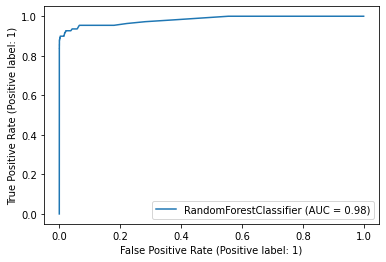

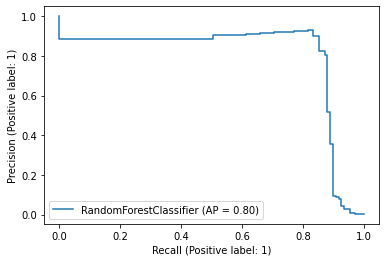

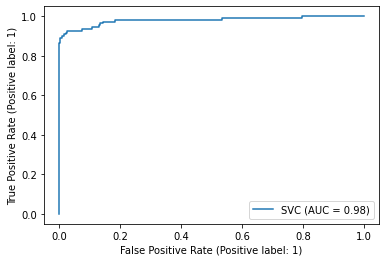

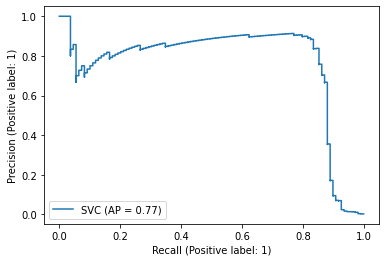

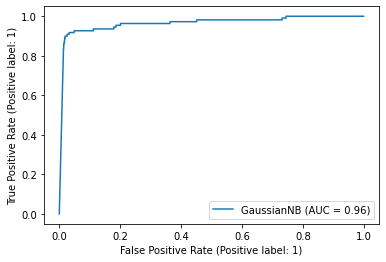

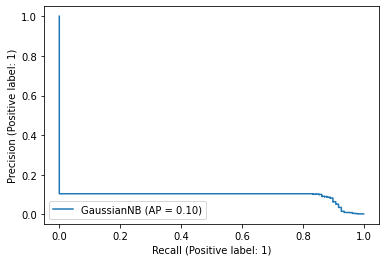

In [18]:
sampler = RandomUnderSampler(sampling_strategy={0: 1915, 1: 383}, random_state=1)

for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")
  X_train_us, y_train_us = sampler.fit_resample(X_train, y_train)

  clf.fit(X_train_us, y_train_us)
  y_pred = clf.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)

  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  
  print(classification_report_imbalanced(y_test, y_pred))


  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

  print("------------------------------------------------------\n")

**Method 3: NearMiss**

*version 1*

Random Forest
------------------------------------------------------
Confusion matrix
[[ 7882 48971]
 [    1   108]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.14      0.99      0.24      0.37      0.13     56853
          1       0.00      0.99      0.14      0.00      0.37      0.15       109

avg / total       1.00      0.14      0.99      0.24      0.37      0.13     56962

------------------------------------------------------

Linear SVM
------------------------------------------------------
Confusion matrix
[[31139 25714]
 [    7   102]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.55      0.94      0.71      0.72      0.49     56853
          1       0.00      0.94      0.55      0.01      0.72      0.53       109

avg / total       1.00      0.55      0.94      0.71      0.72      0.49     56962

---------------------------------------

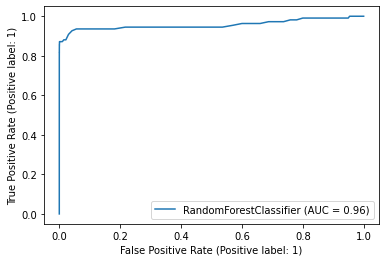

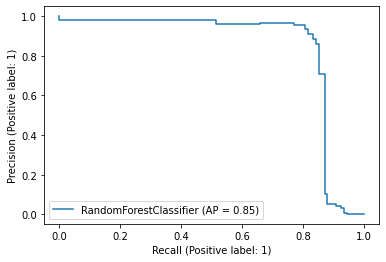

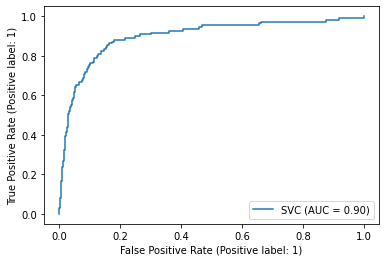

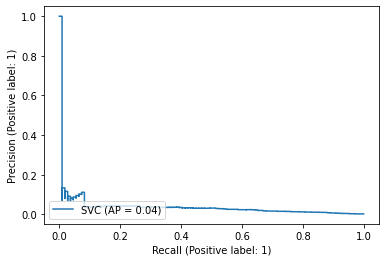

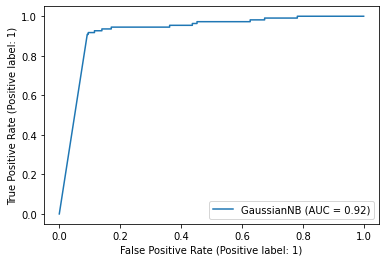

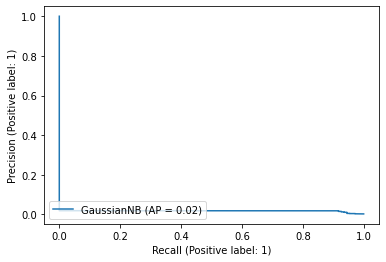

In [19]:

for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")

  pipeline = make_pipeline(NearMiss(version=1),clf)
  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)

  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  
  print(classification_report_imbalanced(y_test, y_pred))

  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

  print("------------------------------------------------------\n")

*version 2*

Random Forest
------------------------------------------------------
Confusion matrix
[[ 1959 54894]
 [    1   108]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.03      0.99      0.07      0.18      0.03     56853
          1       0.00      0.99      0.03      0.00      0.18      0.04       109

avg / total       1.00      0.04      0.99      0.07      0.18      0.03     56962

------------------------------------------------------

Linear SVM
------------------------------------------------------
Confusion matrix
[[11020 45833]
 [    3   106]] 

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.19      0.97      0.32      0.43      0.17     56853
          1       0.00      0.97      0.19      0.00      0.43      0.20       109

avg / total       1.00      0.20      0.97      0.32      0.43      0.17     56962

---------------------------------------

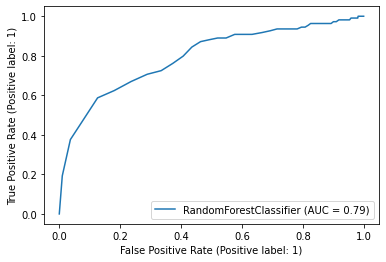

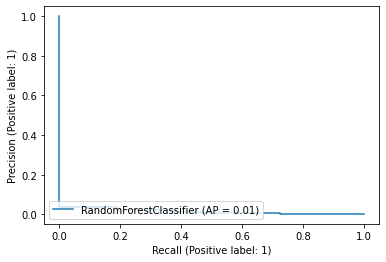

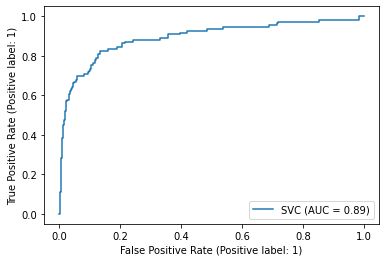

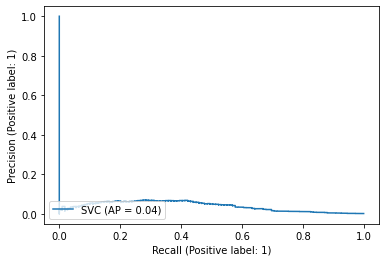

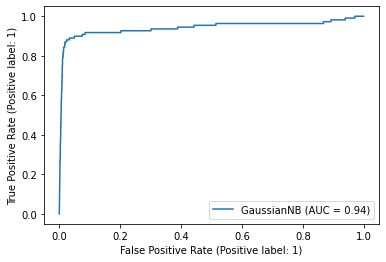

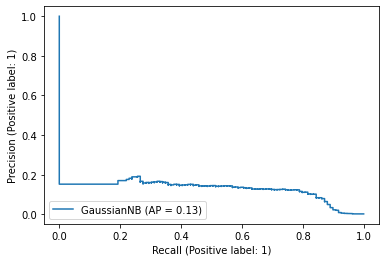

In [20]:

for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")

  pipeline = make_pipeline(NearMiss(version=2),clf)
  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)
  conf_m = confusion_matrix(y_test, y_pred)

  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  
  print(classification_report_imbalanced(y_test, y_pred))

  RocCurveDisplay.from_estimator(clf, X_test, y_test)
  PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

  print("------------------------------------------------------\n")

The second version should have worked better because it picks the points further from the majority class, so at least the linear svm should have had a small improvement.